In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, SparsePCA

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


## Data preprocessing

In [3]:
#X_new and y_new came from train.csv
X = pd.read_csv('/Users/mercuryliu/Documents/Kaggle/ga-customer-revenue-prediction/X_v2.csv', \
                low_memory=False).drop(['visitHour', 'Unnamed: 0'], axis=1)
y = pd.read_csv('/Users/mercuryliu/Documents/Kaggle/ga-customer-revenue-prediction/y_v2.csv').drop('Unnamed: 0', axis=1)


### Transformation on Y

In [4]:
#transform y to the submission form
y_log = np.log(y + 1)

In [6]:
len(X.columns)

26

### Test Train Data Split 

In [7]:
#did not do PCA on X bc we are going to use tree-based models
#dataset without PCA on X
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

In [9]:
#remeber to reshape y to 1d array, otherwise warning message would be raised
y_train = y_train.to_numpy().reshape(len(y_train),)
y_test = y_test.to_numpy().reshape(len(y_test),)


## Dimensionality Reduction

In [14]:
X_train.shape

(83484, 26)

In [ ]:
#I was trying to use Gridsearch CV and apply it on the original dataset, but the high dimensionlaity 
#(83484, 26) makes it super expensive computationally
#Since I am less interested in individual variables but want to build up a model(black box method
#)I decided to reduce the dimension of the data through PCA
#Even though I have learned some algorithms, I don't think it is wrong to apply black box method
#I learn the most after I apply an algorithm and try to improve it
#The goal of improving it will push me to fully understand the math behind before modifying it 


In [15]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

In [30]:
var = []
for i in range(5, 25, 1):
    pca = PCA(n_components = i)
    X_train_r = pca.fit_transform(X_train_s)
    k = np.sum(pca.explained_variance_ratio_)
    var.append(k)


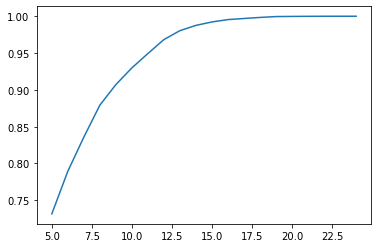

In [31]:
#Since I want a dataset that can explain at least 95% of the variance
#set n_components = 12
plt.plot(list(range(5, 25, 1)), var)
plt.show()

In [32]:
pca_train = PCA(n_components = 12)
X_train_r = pca_train.fit_transform(X_train_s)

In [33]:
pca_test = PCA(n_components = 12)
X_test_r = pca_test.fit_transform(X_test_s)

In [38]:
#check if the expalined_variance_ratio is greater than 95%
np.sum(pca_train.explained_variance_ratio_)> 0.95

True

In [39]:
np.sum(pca_test.explained_variance_ratio_)> 0.95

True

## Model Tuning & Evaluation
#Since in the basic model, the performance of the model using data without PCA is better
#In the following model tuning process, all the data are without PCA
#parameters to tune are based on: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [40]:
#This cell took about 14h to run
parameters = {'n_estimators': list(range(50, 150, 10)), \
              'max_depth': list(range(5, 50, 5)),\
             'min_samples_leaf': list(range(20, 140, 20))}
model = GradientBoostingRegressor(loss='ls', criterion='mse', max_features='sqrt',\
                                  random_state= 2, learning_rate=0.05)
md = GridSearchCV(model, parameters, cv=3, scoring='neg_mean_squared_error')
md.fit(X_train_r, y_train)


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 learning_rate=0.05,
                                                 max_features='sqrt',
                                                 random_state=2),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45],
                         'min_samples_leaf': [20, 40, 60, 80, 100, 120],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140]},
             scoring='neg_mean_squared_error')

In [42]:
md.best_params_

{'max_depth': 20, 'min_samples_leaf': 20, 'n_estimators': 70}

In [ ]:
##Model Comparison 

In [43]:
m_best = GradientBoostingRegressor(n_estimators=70, max_depth=20, min_samples_leaf=20,\
                                  loss='ls', learning_rate=0.05, criterion='mse',\
                                  max_features='sqrt', random_state=2)

In [44]:
#part1: no cv
m_best.fit(X_train_r, y_train) #fit model
#training error
p1_train = m_best.predict(X_train_r)
train_e = mean_squared_error(y_train, p1_train) 
#testing error
p2_test = m_best.predict(X_test_r) 
test_e = mean_squared_error(y_test, p2_test)     


In [45]:
#part2: same model & parameters, but do 3-fold cv, get average MSE
cv_e = - (np.mean(cross_val_score(m_best, X_train_r, y_train, \
                                    cv=3, scoring ='neg_mean_squared_error')))


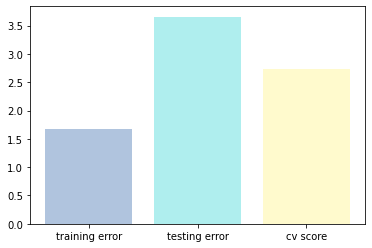

In [46]:
e_combo = [train_e, test_e, cv_e]
name = ['training error', 'testing error', 'cv score']
c = ['lightsteelblue', 'paleturquoise', 'lemonchiffon']
plt.bar(name, e_combo, color = c)
plt.show()